In [1]:
import matplotlib.patches as patches
from HexDetector import hex_radius_inner_to_outer
from test_functions import *

set_matplotlib_style()

In [2]:
# run_path = '/home/akallits/Documents/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'
# run_path = '/local/home/dn277127/Bureau/picosec/Run243-Pool4_treeParam.root'
# run_path = '/home/dylan/Desktop/picosec/Run243-Pool4_treeParam.root'
run_path = '/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root'

In [3]:
tree = get_tree(run_path, 'ParameterTree')

In [4]:
event_start, event_end = 4416, None
min_ampl, max_ampl = -2, 2  # V
min_charge, max_charge = -0, 50.0  # fC
min_charge_tot, max_charge_tot = -0, 100.0  # fC
xy_range_min, xy_range_max = -100, 100  # mm


In [5]:
channels = ['C1', 'C2', 'C4']
global_vars = ['eventNo']
channel_vars = ['hitX', 'hitY']
peak_param_channel_vars = ['ampl', 'dampl', 'charge', 'echarge', 'echargefit', 'echargefixed', 'totcharge', 'totchargefixed', 'risetime', 'tfit20','tfit20_nb', 'tnaive20', 'sigmoidR[4]']

branches = []
for channel in channels:
    for channel_var in channel_vars:
        branches.append(f'{channel_var}_{channel}')
    for var in peak_param_channel_vars:
        branches.append(f'peakparam_{channel}/peakparam_{channel}.{var}')
for var in global_vars:
    branches.append(var)
df = get_df_branches(tree, branches)

if event_start is not None:
    df = df[df['eventNo'] >= event_start]
if event_end is not None:
    df = df[df['eventNo'] <= event_end]

<Report start=0 stop=30400 source='/data/akallits/Saclay_Analysis/data/data/2023_April_h4/processedTrees/ParameterTrees/Run243-Pool4_treeParam.root:/ParameterTree;1'>


In [6]:
for channel in channels:
    get_single_peak(df, channel)
    
median_x, median_y = get_center_all_tracks(df, 'C1')
get_closest_track_indices(df, 'C1', (median_x, median_y))



In [7]:
for channel in channels:
    for xy in ['X', 'Y']:
        col_name = f'hit{xy}_{channel}'
        df[col_name] = df.apply(lambda row: row[col_name][int(row['closest_hit_index'])] if isinstance(row[col_name], list) and ~np.isnan(row['closest_hit_index']) else np.nan, axis=1)


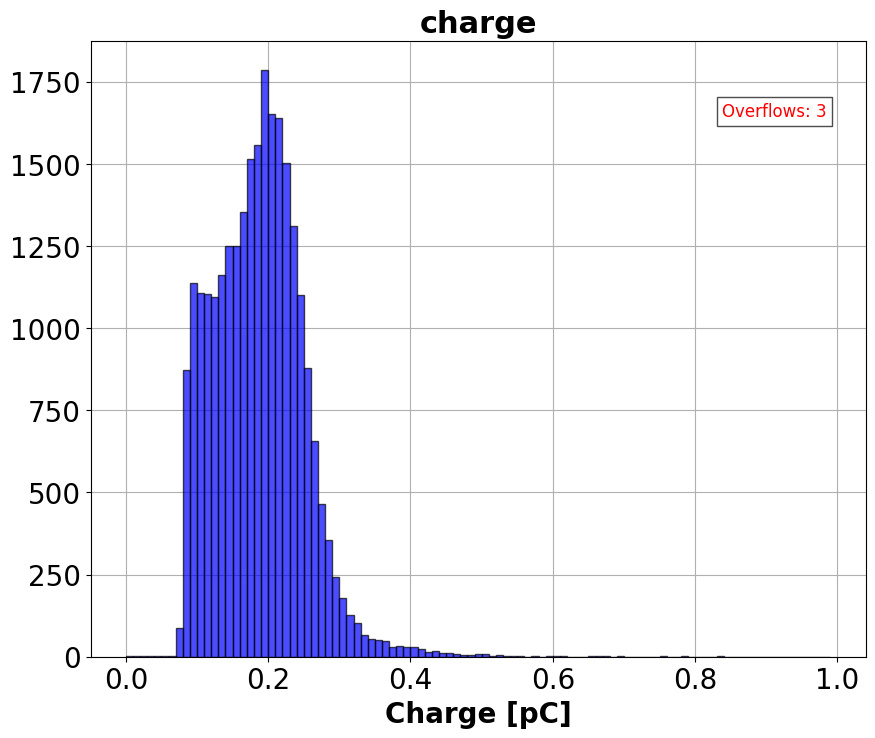

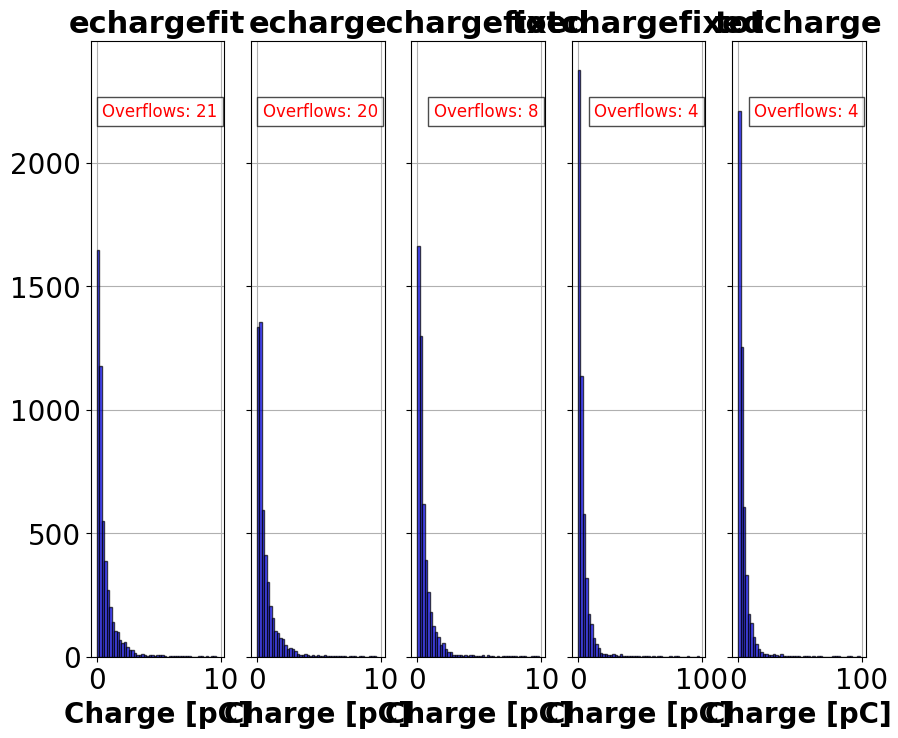

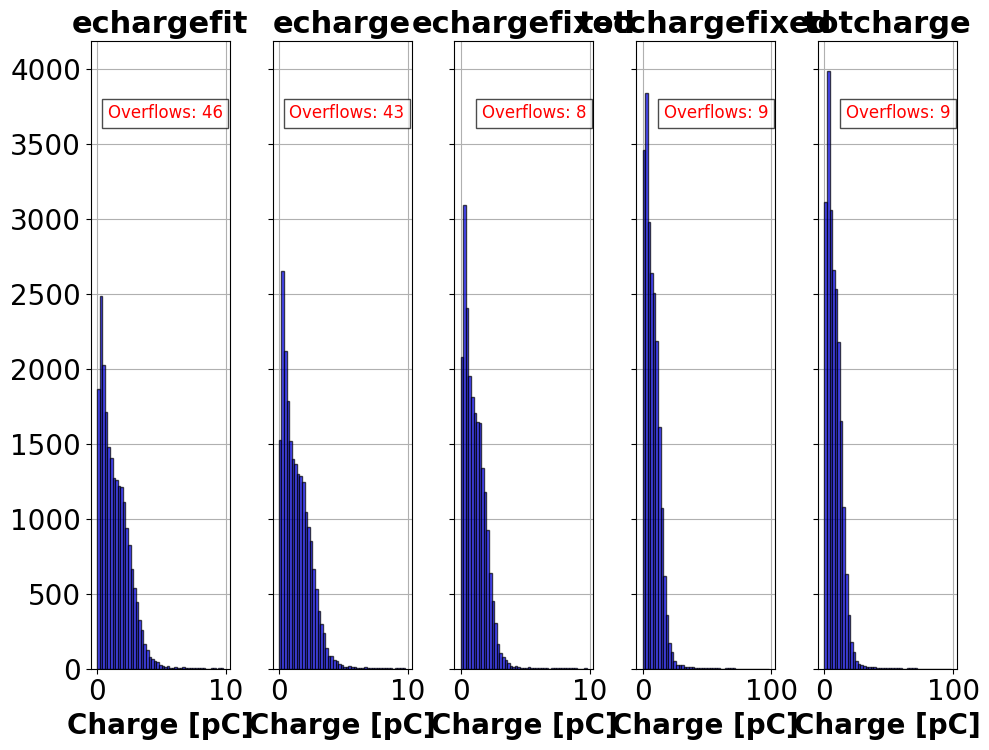

In [8]:
# Loop over channels
mcp_bins = np.arange(0, 1.0, 0.01)
ebins = np.arange(0, 10, 0.2)
totbins = np.arange(0, 100, 2)

for channel in ['C1', 'C2', 'C4']:
    if channel == 'C1':
        charge_types = ["charge"]
    else:
        charge_types = ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"]

    num_charges = len(charge_types)

    fig, axes = plt.subplots(1, num_charges, figsize=(10,8), sharey=True)

    # Ensure axes is always iterable (wrap in list if only one subplot)
    if num_charges == 1:
        axes = [axes]

    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    for i, charge_type in enumerate(charge_types):
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins

        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            if channel == 'C1':
                binning = mcp_bins

        n_overflows = np.sum(charge_data > binning[-1])
        axes[i].hist(filtered_data, bins=binning, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        axes[i].set_title(charge_type)
        axes[i].set_xlabel('Charge [pC]')
        axes[i].grid(True, zorder=0)
        # Add overflow text
        axes[i].text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=axes[i].transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Add a background box
        )
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.savefig(f'charge_histograms_{channel}.pdf', dpi=300)
plt.savefig(f'charge_histograms_{channel}.png', dpi=300)

/tmp/ipykernel_2699496/1610103006.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(title="Charge Types")


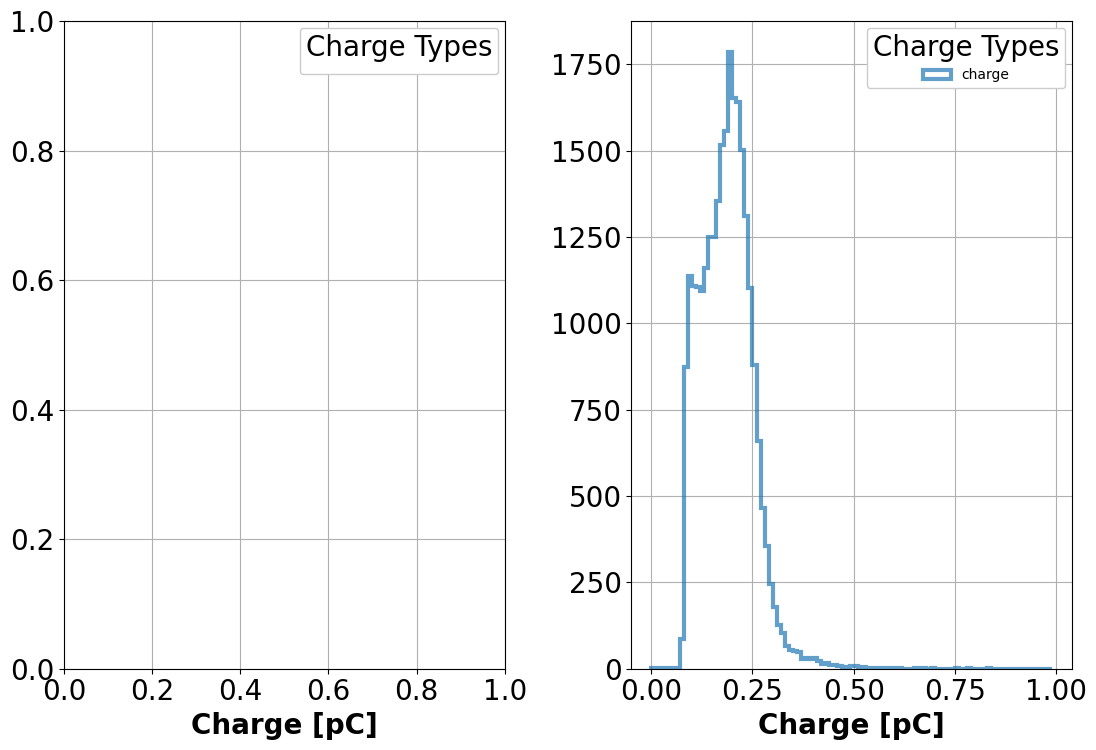

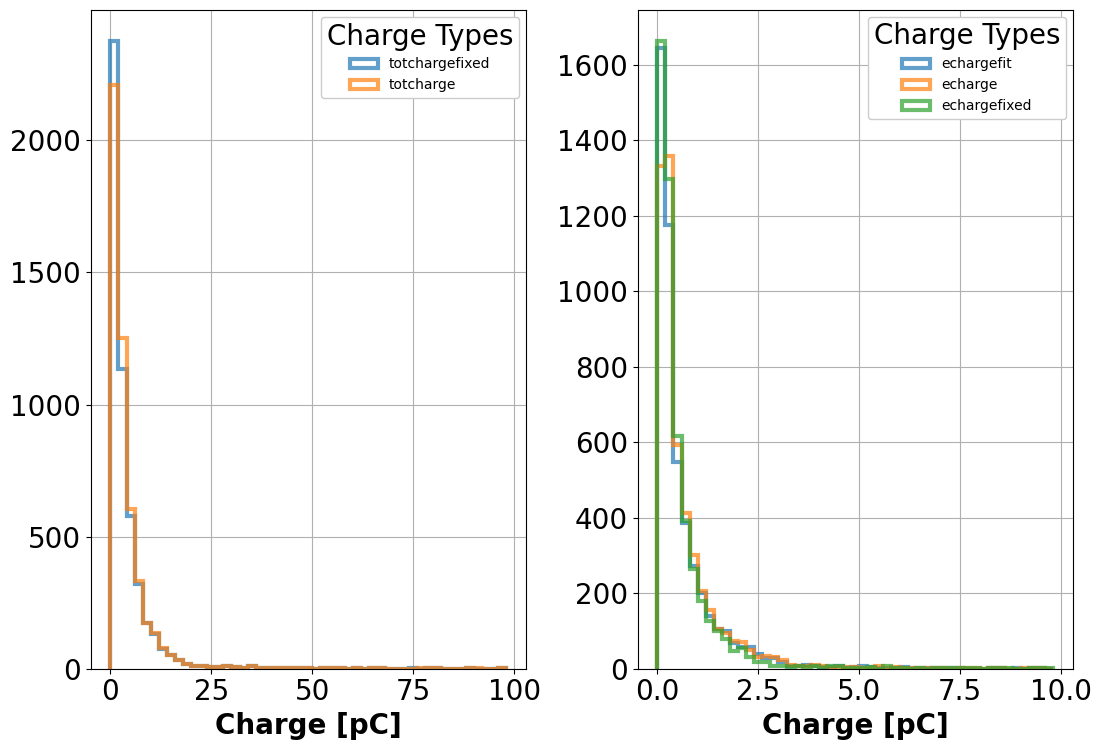

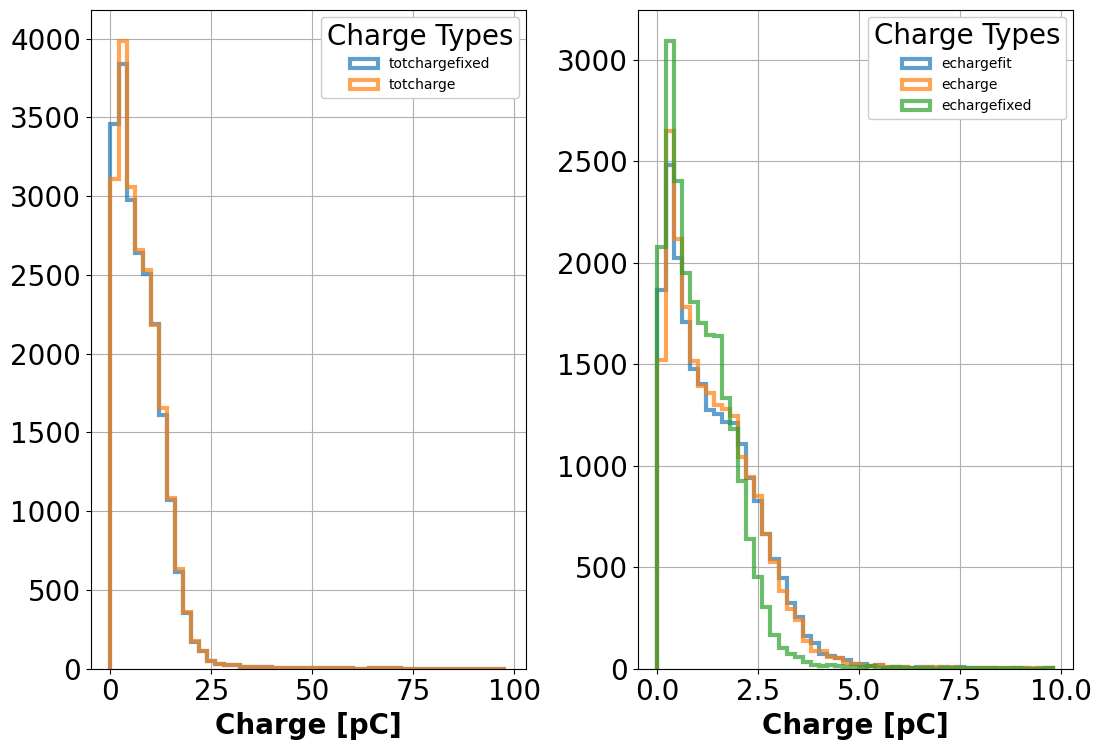

In [9]:
channel_charge_types = {
    'C1': ["charge"],
    'C2': ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"],
    'C4': ["echargefit", "echarge", "echargefixed", "totchargefixed", "totcharge"]
}

# Loop through the channels you want to plot
for channel in ['C1', 'C2', 'C4']:
    charge_types = channel_charge_types[channel]  # Select charge types based on the channel

    fig, axs = plt.subplots(ncols=2, figsize=(11, 8))  # Create figure with 2 subplots (ncols=2)

    # Loop over each charge type for the current channel
    for charge_type in charge_types:
        key = f'peakparam_{channel}/peakparam_{channel}.{charge_type}'
        charge_data = df[key]

        # Apply filters based on the charge type (e.g., total charge vs. echarge)
        if "totcharge" in charge_type:
            filtered_data = charge_data[(charge_data > min_charge_tot) & (charge_data < max_charge_tot)]
            binning = totbins
            ax_num = 0  # First subplot (totcharge)
        else:
            filtered_data = charge_data[(charge_data > min_charge) & (charge_data < max_charge)]
            binning = ebins
            ax_num = 1  # Second subplot (echarge)
            if channel == 'C1':
                binning = mcp_bins  # Special binning for C1

        # Plot the histogram
        n, bins, _ = axs[ax_num].hist(filtered_data, bins=binning, alpha=0.7, label=charge_type,
                                      zorder=2, histtype='step', linewidth=3)

        # Optional: Adding labels on top of histogram lines (bins)
        for i in range(len(bins)-1):
            # Find the position to put the label (at the middle of each bin)
            bin_center = (bins[i] + bins[i+1]) / 2
            count = n[i]  # Get the count (height) of the histogram at this bin
            # axs[ax_num].text(bin_center, count, f'{int(count)}', ha='center', va='bottom', fontsize=8)

    # Customize the plots
    axs[0].set_xlabel('Charge [pC]')
    axs[0].grid(True)
    axs[1].set_xlabel('Charge [pC]')
    axs[1].grid(True)

    # Add legends to the subplots
    axs[0].legend(title="Charge Types")
    axs[1].legend(title="Charge Types")

    # Set title for the current channel
    # fig.suptitle(f"Histograms of Charges for {channel}", fontsize=14)

    # Adjust the layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show plot for the current channel
    plt.show()

In [10]:
filters = {channel: {} for channel in channels}
for channel in channels:
    
    tot_charge_data = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
    filters[channel].update({'totcharge_cut': (tot_charge_data > min_charge_tot) & (tot_charge_data < max_charge_tot)})

    charge_data = df[f'peakparam_{channel}/peakparam_{channel}.charge']
    filters[channel].update({'charge_cut': (charge_data > min_charge_tot) & (charge_data < max_charge_tot)})

    ampl_data = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    filters[channel].update({'ampl_cut': (ampl_data > min_ampl) & (ampl_data < max_ampl)})

    dampl_data = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
    filters[channel].update({'dampl_cut': (dampl_data > min_ampl) & (dampl_data < max_ampl)})

    echarge_fit_data = df[f'peakparam_{channel}/peakparam_{channel}.echargefit']
    filters[channel].update({'echargefit_cut': (echarge_fit_data > min_charge) & (echarge_fit_data < max_charge)})

    #xy_filter_cut = (first_c_xs > -100) & (first_c_xs < 100) & (first_c_ys > -100) & (first_c_ys < 100)
    
    x_data = df[f'hitX_{channel}']
    y_data = df[f'hitY_{channel}']
    
    xy_filter_cut = (x_data > xy_range_min) & (x_data < xy_range_max) & (y_data > xy_range_min) & (y_data < xy_range_max)
    filters[channel].update({'xy_cut': xy_filter_cut})
    
    
    
# print(filters)

# mm_basic_charge_cut = (0.2 < df['peakparam_C4/peakparam_C4.totcharge_filtered']) & (df['peakparam_C4/peakparam_C4.totcharge_filtered'] < 100)
# mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 2)
# good_mm_mcp_charge_events = mm_basic_charge_cut & mcp_basic_charge_cut

# Get filtered dataframes for each channel -- charge filter 
c1_charge_filtered_df = df[filters['C1']['charge_cut']] 
c2_charge_filtered_df = df[filters['C2']['totcharge_cut']]
c4_charge_filtered_df = df[filters['C4']['totcharge_cut']] 

#Get the tracks for the filtered dataframes
# c1_charge_filtered_df = df[filters['C1']['xy_cut']]

x_c1_filtered = c1_charge_filtered_df[f'hitX_C1']
y_c1_filtered = c1_charge_filtered_df[f'hitY_C1']
x_c4_filtered = c4_charge_filtered_df[f'hitX_C4']
y_c4_filtered = c4_charge_filtered_df[f'hitY_C4']


# x_c1_filtered = df[filters['C1']['totcharge_cut']][f'hitX_C1']
# y_c1_filtered = df[filters['C1']['totcharge_cut']][f'hitY_C1']
# x_c4_filtered = df[filters['C4']['totcharge_cut']][f'hitX_C4']
# y_c4_filtered = df[filters['C4']['totcharge_cut']][f'hitY_C4']
# x_c1_filtered = df[filters['C1']['xy_cut']][f'hitX_C1']
# y_c1_filtered = df[filters['C1']['xy_cut']][f'hitY_C1']
# x_c4_filtered = df[filters['C4']['xy_cut']][f'hitX_C4']
# y_c4_filtered = df[filters['C4']['xy_cut']][f'hitY_C4']

In [11]:
print(c1_charge_filtered_df.shape)
print(c4_charge_filtered_df.shape)
print(x_c1_filtered.shape)
print(y_c1_filtered.shape)
print(x_c4_filtered.shape)
print(y_c4_filtered.shape)

(25984, 47)
(21770, 47)
(25984,)
(25984,)
(21770,)
(21770,)


In [12]:
# channels = ['C1', 'C2', 'C4']
# filter_dict = {}
# for channel in channels:
#     first_c_xs = df[f'hitX_{channel}']
#     first_c_xs = np.array(first_c_xs)
#     first_c_ys = df[f'hitY_{channel}']
#     first_c_ys = np.array(first_c_ys)
#
#     xy_filter_cut = (first_c_xs > -100) & (first_c_xs < 100) & (first_c_ys > -100) & (first_c_ys < 100)
#
#     first_c_xs_plt = first_c_xs[xy_filter_cut]
#     median_x = np.median(first_c_xs_plt)
#
#     first_c_ys_plt = first_c_ys[xy_filter_cut]
#     median_y = np.median(first_c_ys_plt)
#
#     fig, ax = plt.subplots()
#     ax.scatter(first_c_xs_plt, first_c_ys_plt, s=1)
#     ax.scatter(median_x, median_y, s=10, c='red', marker='x')
#     ax.set_title(f'X vs Y position of first peak in {channel} channel')
#     ax.set_xlabel('X [mm]')
#     ax.set_ylabel('Y [mm]')
#
#     # Select events within 10 mm of the median
#     r = np.sqrt((first_c_xs - median_x)**2 + (first_c_ys - median_y)**2)
#     # filter = (1 < r) & (r < 3)
#     filter = r < 3
#     first_c_xs_filtered = first_c_xs[filter]
#     first_c_ys_filtered = first_c_ys[filter]
#     median_x = np.median(first_c_xs_filtered)
#     median_y = np.median(first_c_ys_filtered)
#
#     filter_dict.update({channel: filter})
#
#     fig, ax = plt.subplots()
#     ax.scatter(first_c_xs_filtered, first_c_ys_filtered, s=1)
#     ax.scatter(median_x, median_y, s=10, c='red', marker='x')
#     ax.set_title(f'X vs Y position of first peak in {channel} channel (filtered)')
#     ax.set_xlabel('X [mm]')
#     ax.set_ylabel('Y [mm]')
#
#
# plt.show()


C1 Number of outliers: 0 of 25984
C1 Number after filter: 25984 of 25984
C1 channel: min = 0.0067010960068495315, max = 1.1877907654227633
C2 Number of outliers: 5 of 4988
C2 Number after filter: 4983 of 4988
C2 channel: min = 0.13149981795361282, max = 97.66794550557336
C4 Number of outliers: 11 of 21781
C4 Number after filter: 21770 of 21781
C4 channel: min = 0.20159773797738173, max = 95.33508035433051


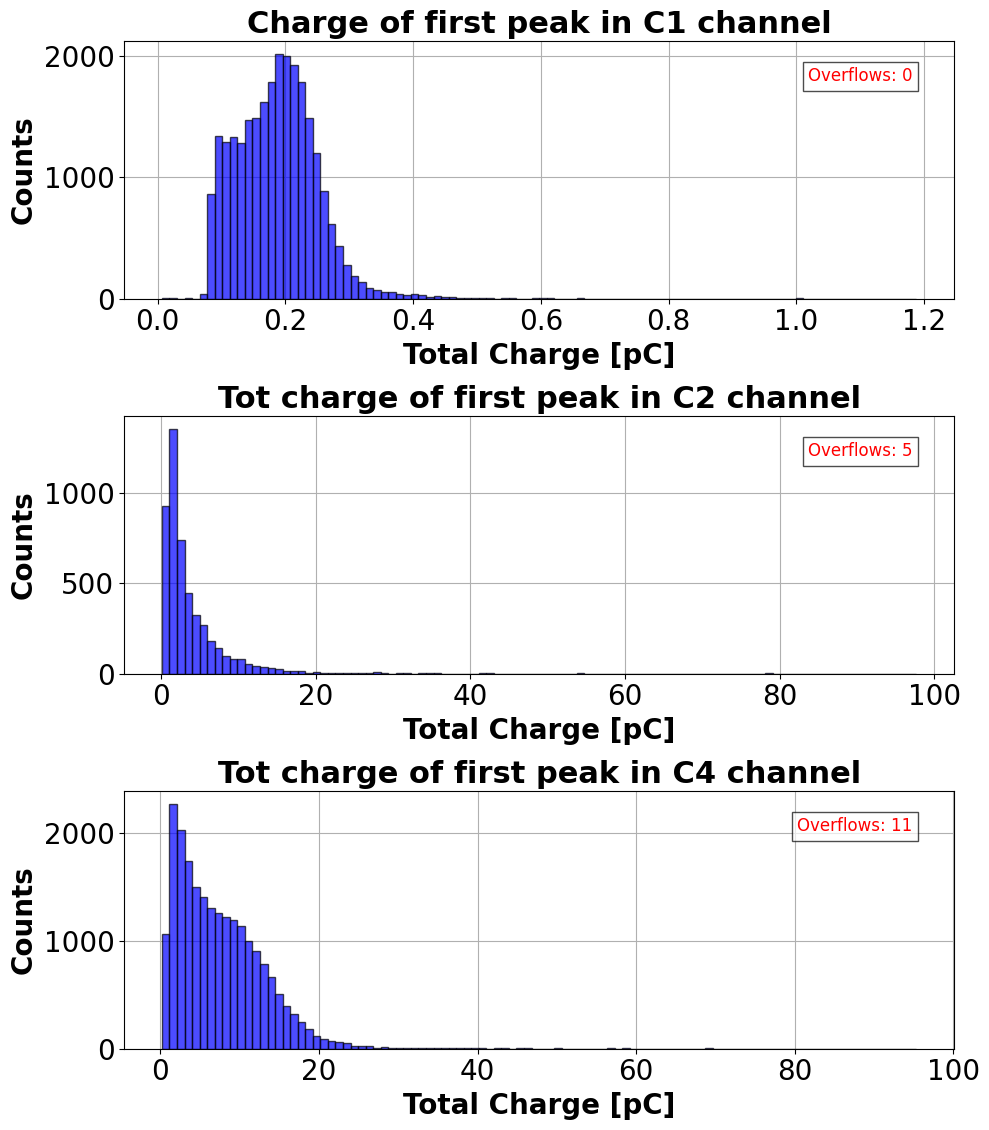

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))  # 3 rows, 1 column

for i, channel in enumerate(['C1', 'C2', 'C4']):
    # Get first charge or total charge based on the channel
    if channel == 'C1':
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.charge']
        df_filter = df[filters[channel]['charge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.charge']
    else:
        first_charges_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.totcharge']
        df_filter = df[filters[channel]['totcharge_cut']]
        first_charges_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.totcharge']

    # Convert to numpy arrays for filtering
    n_overflows = np.sum(first_charges_unfiltered < min_charge_tot) + np.sum(first_charges_unfiltered > max_charge_tot)  # Overflow count
    n_in_range = len(first_charges_filtered)
    n_total = n_in_range + n_overflows

    # Print outliers information
    print(f'{channel} Number of outliers: {n_overflows} of {n_total}')
    print(f'{channel} Number after filter: {len(first_charges_filtered)} of {n_total}')
    print(f'{channel} channel: min = {np.nanmin(first_charges_filtered)}, max = {np.nanmax(first_charges_filtered)}')

    # Plot each channel's charge histogram
    ax = axes[i]  # Use the appropriate axis in the grid
    ax.hist(first_charges_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)

    # Set title based on the channel
    if channel == 'C1':
        ax.set_title(f'Charge of first peak in {channel} channel')
    else:
        ax.set_title(f'Tot charge of first peak in {channel} channel')

    # Set labels
    ax.set_xlabel('Total Charge [pC]')
    ax.set_ylabel('Counts')

    # Add overflow text
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    ax.grid(True, zorder=0)

# Adjust layout to avoid overlap and ensure titles fit
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap

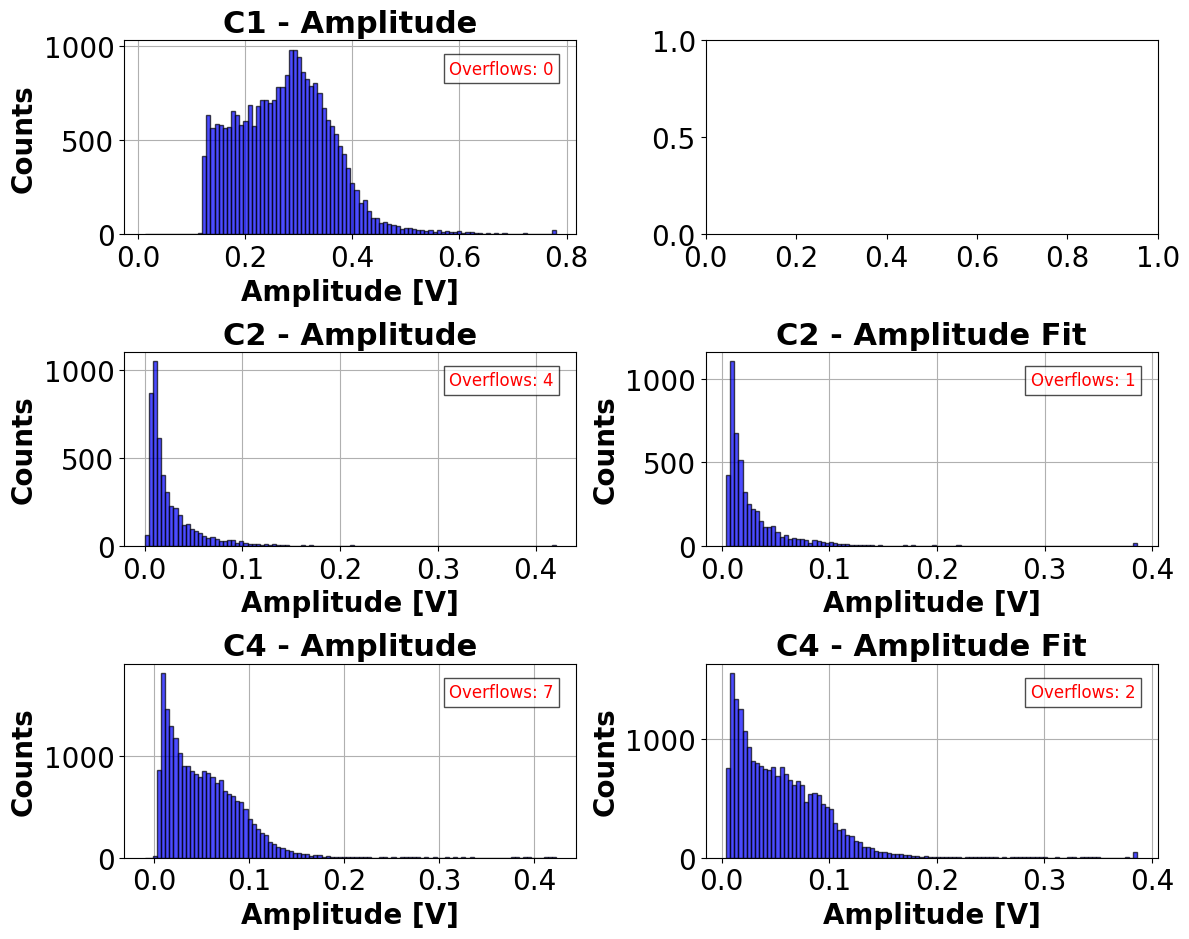

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))  # 3 rows, 2 columns

for i, channel in enumerate(['C1', 'C2', 'C4']):
    # First peak amplitude histogram
    first_ampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.ampl']
    df_filter = df[filters[channel]['ampl_cut']]
    first_ampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.ampl']

    n_overflows = np.sum(first_ampls_unfiltered < min_ampl) + np.sum(first_ampls_unfiltered > max_ampl)  # Overflow count
    n_in_range = len(first_ampls_filtered)
    n_total = n_in_range + n_overflows

    # Plot first_ampls_filtered histogram
    ax = axes[i, 0]  # Left column
    ax.hist(first_ampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
    ax.set_title(f'{channel} - Amplitude')
    ax.set_xlabel('Amplitude [V]')
    ax.set_ylabel('Counts')
    ax.grid(True, zorder=0)

    # Add overflow text for first_ampls
    ax.text(
        0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
        f'Overflows: {n_overflows}',
        transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
        fontsize=12, color='red', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
    )

    # For C2 and C4, add the second amplitude (dampl) plot
    if channel in ['C2', 'C4']:
        first_dampls_unfiltered = df[f'peakparam_{channel}/peakparam_{channel}.dampl']
        df_filter = df[filters[channel]['dampl_cut']]
        first_dampls_filtered = df_filter[f'peakparam_{channel}/peakparam_{channel}.dampl']

        n_overflows = np.sum(first_dampls_unfiltered < min_ampl) + np.sum(first_dampls_unfiltered > max_ampl)  # Overflow count
        n_in_range = len(first_dampls_filtered)
        n_total = n_in_range + n_overflows

        # Plot first_dampls_filtered histogram
        ax = axes[i, 1]  # Right column
        ax.hist(first_dampls_filtered, bins=100, alpha=0.7, color='blue', edgecolor='black', zorder=2)
        ax.set_title(f'{channel} - Amplitude Fit')
        ax.set_xlabel('Amplitude [V]')
        ax.set_ylabel('Counts')
        ax.grid(True, zorder=0)

        # Add overflow text for first_dampls
        ax.text(
            0.95, 0.9,  # Position (relative to axes, 95% right, 90% up)
            f'Overflows: {n_overflows}',
            transform=ax.transAxes,  # Use axes coordinates (0,0 is bottom-left, 1,1 is top-right)
            fontsize=12, color='red', ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')  # Background box
        )

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap
plt.savefig('amplitude_histograms.pdf', dpi=300)

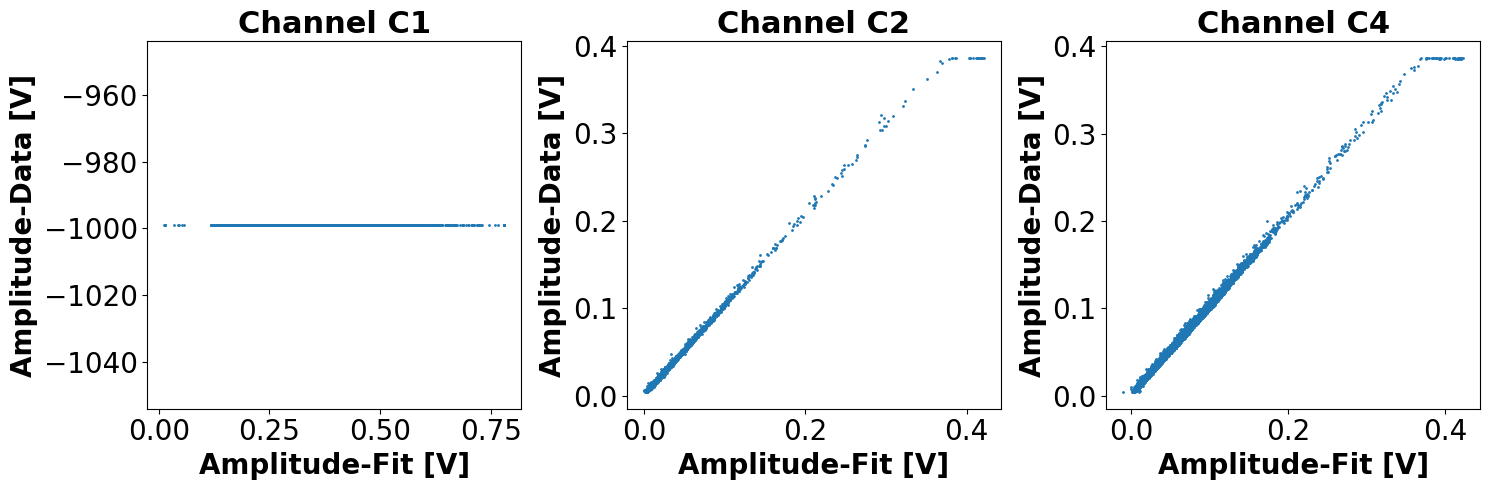

In [15]:
channels = filters.keys()  # Get all available channels
num_channels = len(channels)

fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(5*num_channels, 5))

if num_channels == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

for ax, ch in zip(axes, channels):
    df_filter = df[filters[ch]['ampl_cut']]
    ampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    dampl_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.dampl']

    ax.scatter(ampl_filtered, dampl_filtered, s=1)
    ax.set_title(f'Channel {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.set_ylabel('Amplitude-Data [V]')
# fig.text(0.5, 0.02, 'Amplitude-Fit [V]', ha='center', fontsize=12)
plt.tight_layout()

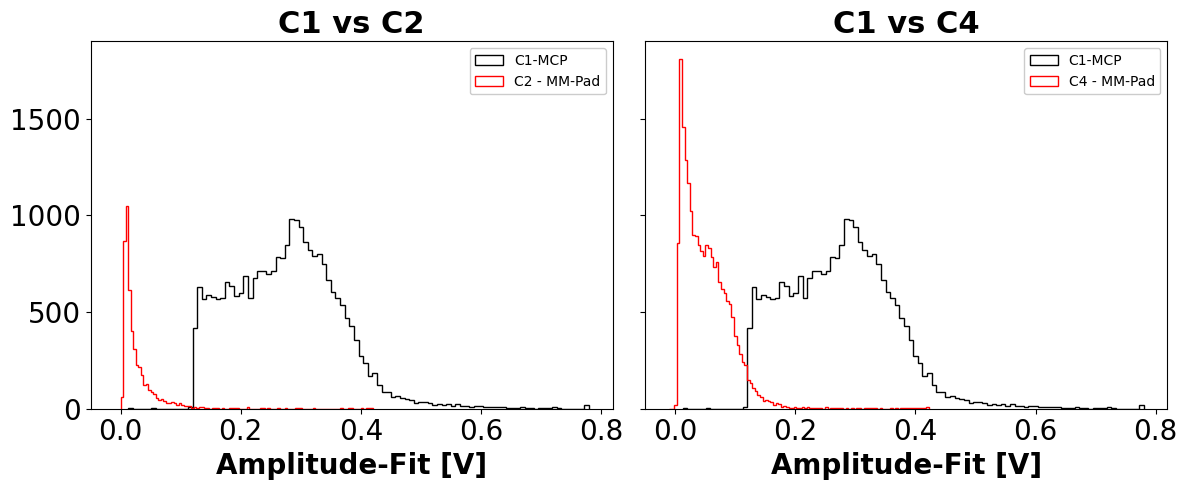

In [16]:
compare_ch_ampl = [ch for ch in filters.keys() if ch != 'C1']

num_plots = len(compare_ch_ampl)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(6*num_plots, 5), sharex=True, sharey=True)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_c1 = df[filters['C1']['ampl_cut']]
c1_ampl_filtered = df_filter_c1['peakparam_C1/peakparam_C1.ampl']

for ax, ch in zip(axes, compare_ch_ampl):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['ampl_cut']]
    ch_ampl_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.ampl']

    # Plot histograms
    ax.hist(c1_ampl_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    ax.hist(ch_ampl_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch} - MM-Pad')

    # Set title and legend
    ax.set_title(f'C1 vs {ch}')
    ax.set_xlabel('Amplitude-Fit [V]')
    ax.legend()

plt.tight_layout()

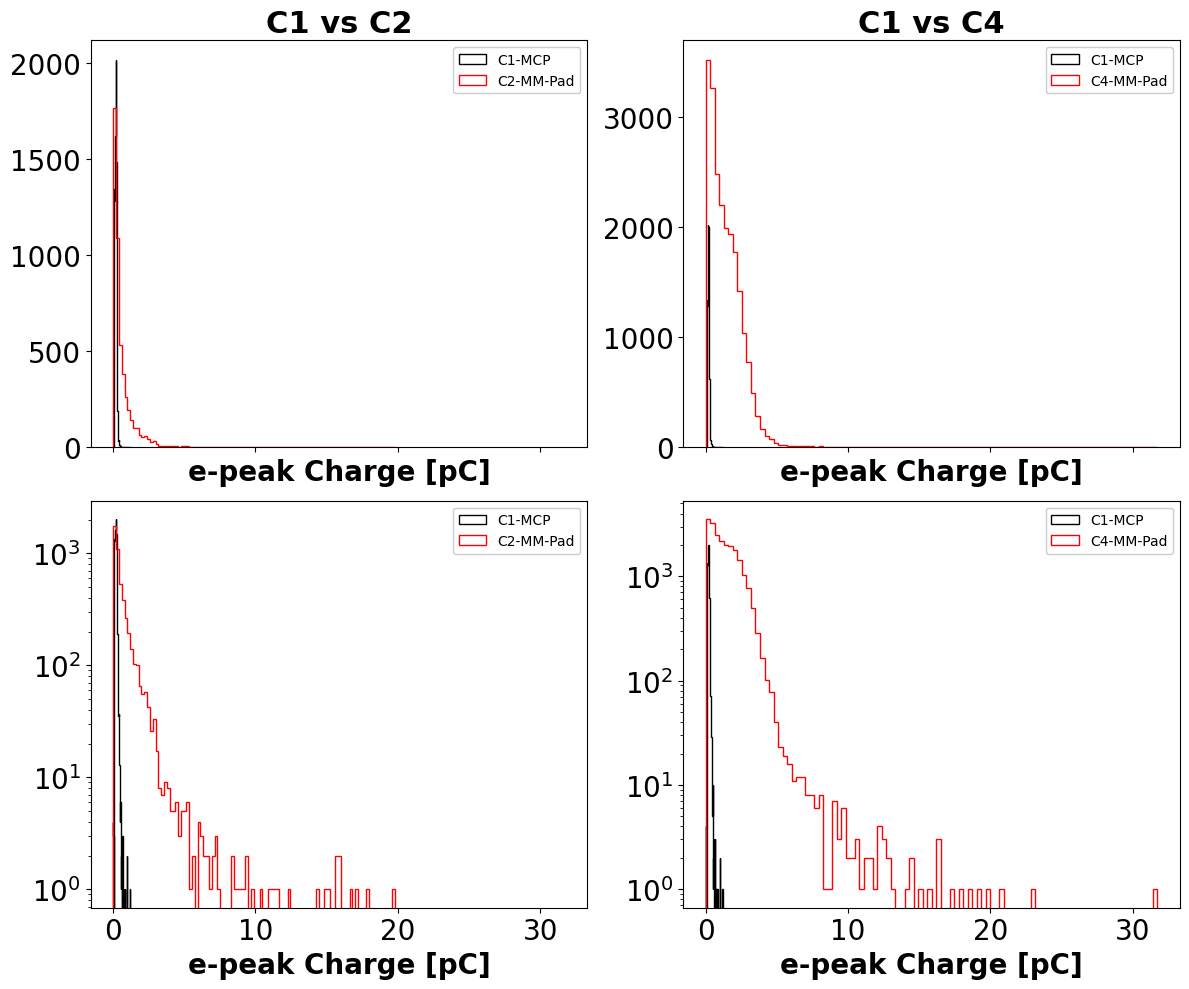

In [17]:
# Get all channels except C1
compare_ch_charge = [ch for ch in filters.keys() if ch != 'C1']

num_plots = len(compare_ch_charge)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_c1 = df[filters['C1']['charge_cut']]
c1_ch_filtered = df_filter_c1['peakparam_C1/peakparam_C1.charge']

for col, ch in enumerate(compare_ch_charge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['echargefit_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # Linear scale histogram (first row)
    axes[0, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[0, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[0, col].set_title(f'C1 vs {ch}')
    axes[0, col].set_xlabel('e-peak Charge [pC]')
    axes[0, col].legend()

    # Log scale histogram (second row)
    axes[1, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[1, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[1, col].set_yscale('log')  # Set log scale for y-axis
    axes[1, col].set_xlabel('e-peak Charge [pC]')
    axes[1, col].legend()

plt.tight_layout()

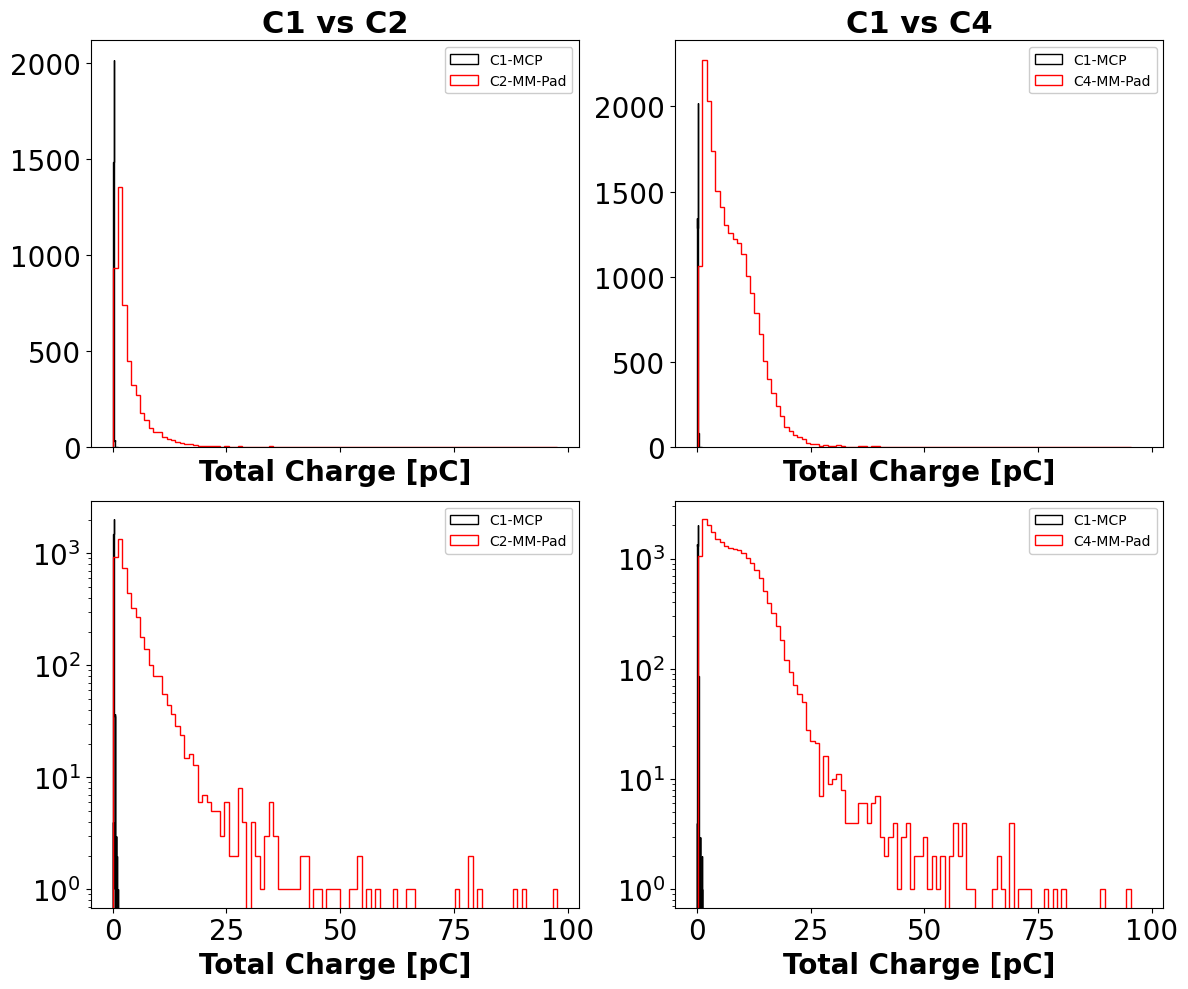

In [18]:
# Get all channels except C1
compare_ch_totcharge = [ch for ch in filters.keys() if ch != 'C1']

num_plots = len(compare_ch_totcharge)
fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=(6*num_plots, 10), sharex=True, sharey=False)

if num_plots == 1:
    axes = [axes]  # Ensure `axes` is iterable when there's only one subplot

# Filter C1 data once (to avoid redundant computation)
df_filter_c1 = df[filters['C1']['charge_cut']]
c1_ch_filtered = df_filter_c1['peakparam_C1/peakparam_C1.charge']

for col, ch in enumerate(compare_ch_totcharge):
    # Apply filter for the other channel
    df_filter_ch = df[filters[ch]['totcharge_cut']]
    ch_ech_filtered = df_filter_ch[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    # Linear scale histogram (first row)
    axes[0, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[0, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[0, col].set_title(f'C1 vs {ch}')
    axes[0, col].set_xlabel('Total Charge [pC]')
    axes[0, col].legend()

    # Log scale histogram (second row)
    axes[1, col].hist(c1_ch_filtered, bins=100, histtype='step', color='black', lw=2, label='C1-MCP')
    axes[1, col].hist(ch_ech_filtered, bins=100, histtype='step', color='red', lw=2, label=f'{ch}-MM-Pad')
    axes[1, col].set_yscale('log')  # Set log scale for y-axis
    axes[1, col].set_xlabel('Total Charge [pC]')
    axes[1, col].legend()

plt.tight_layout()

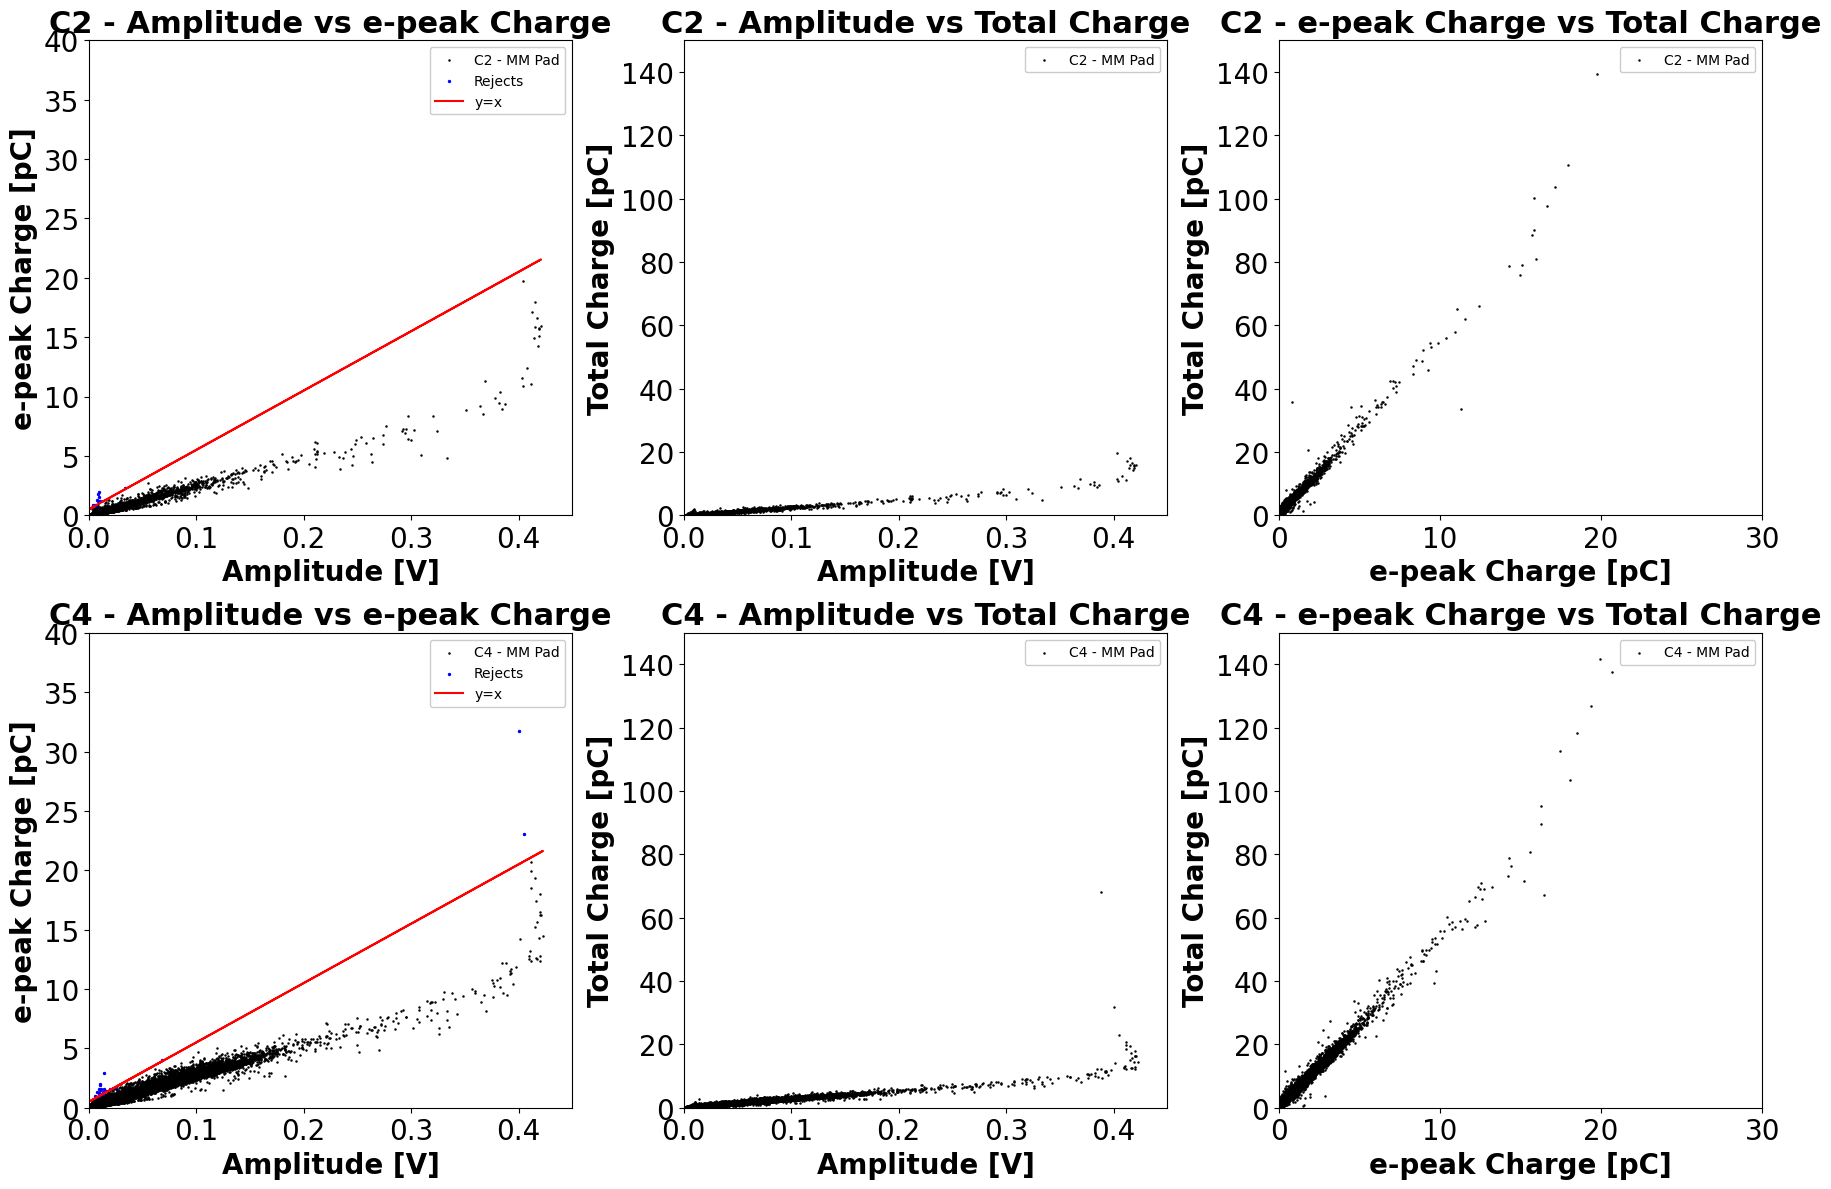

In [19]:
channels = [ch for ch in filters.keys() if ch != 'C1']
num_channels = len(channels)

fig, axs = plt.subplots(nrows=num_channels, ncols=3, figsize=(18, 6*num_channels), sharex=False, sharey=False)

if num_channels == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one channel

# Loop over each channel
for row, ch in enumerate(channels):
    df_filter = df[filters[ch]['ampl_cut']]

    # Extract data
    x_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.ampl']
    y_filtered = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']

    # First scatter plot (Amplitude vs e-peak Charge with rejection line)
    up_slope, up_offset = 50, 0.5
    up_rejects_filter = y_filtered > line(x_filtered, up_slope, up_offset)
    up_rejects_x = x_filtered[up_rejects_filter]
    up_rejects_y = y_filtered[up_rejects_filter]

    axs[row, 0].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row, 0].scatter(up_rejects_x, up_rejects_y, s=2, color='blue', label='Rejects')
    axs[row, 0].plot(np.array(x_filtered), line(np.array(x_filtered), up_slope, up_offset), color='red', label='y=x')

    axs[row, 0].set_xlabel('Amplitude [V]')
    axs[row, 0].set_ylabel('e-peak Charge [pC]')
    axs[row, 0].set_xlim(0, 0.45)
    axs[row, 0].set_ylim(0, 40)
    axs[row, 0].legend()
    axs[row, 0].set_title(f'{ch} - Amplitude vs e-peak Charge')

    # Second scatter plot (Amplitude vs Total Charge)
    axs[row, 1].scatter(x_filtered, y_filtered, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row, 1].set_xlabel('Amplitude [V]')
    axs[row, 1].set_ylabel('Total Charge [pC]')
    axs[row, 1].set_xlim(0, 0.45)
    axs[row, 1].set_ylim(0, 150)
    axs[row, 1].legend()
    axs[row, 1].set_title(f'{ch} - Amplitude vs Total Charge')

    # Third scatter plot (e-peak Charge vs Total Charge)
    x_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.echargefit']
    y_filtered_2 = df_filter[f'peakparam_{ch}/peakparam_{ch}.totcharge']

    axs[row, 2].scatter(x_filtered_2, y_filtered_2, s=0.6, color='black', label=f'{ch} - MM Pad')
    axs[row, 2].set_xlabel('e-peak Charge [pC]')
    axs[row, 2].set_ylabel('Total Charge [pC]')
    axs[row, 2].set_xlim(0, 30)
    axs[row, 2].set_ylim(0, 150)
    axs[row, 2].legend()
    axs[row, 2].set_title(f'{ch} - e-peak Charge vs Total Charge')

plt.tight_layout()
plt.show()

# Get the pad center using the charge weighted method

In [20]:
# # Get filtered dataframes for each channel
# c1_charge_filtered_df = df[filters['C1']['charge_cut']]
# c2_charge_filtered_df = df[filters['C2']['totcharge_cut']]
# c4_charge_filtered_df = df[filters['C4']['totcharge_cut']]
# 

In [21]:
print(c1_charge_filtered_df.shape) #(events, columns)
print(x_c1_filtered.shape) #(events,)
print(y_c1_filtered.shape) #(events,)

(25984, 47)
(25984,)
(25984,)


In [22]:
print(c1_charge_filtered_df.head()) #(events, columns)
print(c1_charge_filtered_df['peakparam_C1/peakparam_C1.charge'].shape) #(events,)

        hitX_C1    hitY_C1  peakparam_C1/peakparam_C1.ampl  \
4416  35.293076  28.785038                        0.191332   
4417  25.653530  28.127159                        0.311535   
4418  26.117359  29.403099                        0.319465   
4419        NaN        NaN                        0.301462   
4420  31.524521  25.177364                        0.273322   

      peakparam_C1/peakparam_C1.dampl  peakparam_C1/peakparam_C1.charge  \
4416                           -999.0                          0.133860   
4417                           -999.0                          0.203303   
4418                           -999.0                          0.219874   
4419                           -999.0                          0.211156   
4420                           -999.0                          0.186704   

      peakparam_C1/peakparam_C1.echarge  peakparam_C1/peakparam_C1.echargefit  \
4416                            -9999.0                               -9999.0   
4417          

In [23]:
get_pad_center_test(c1_charge_filtered_df['peakparam_C1/peakparam_C1.charge'],x_c1_filtered, y_c1_filtered, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot_only=False)

xs: [35.29307556 25.65353012 26.11735916 ... 34.34737396 33.68037415
 27.69223785], ys: [28.78503799 28.12715912 29.40309906 ... 28.05489349 24.44471169
 32.54306793], charges: [0.13386026 0.20330251 0.21987406 ... 0.15857371 0.17899549 0.09112928]
bin_x_min: 4.333428382873535, bin_x_max: 98.74371337890625
bin_y_min: 2.0244085788726807, bin_y_max: 2.0244085788726807


/sw/akallits/PicoAnalysis/Saclay_Analysis/py_analysis/venv/bin/python/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/sw/akallits/PicoAnalysis/Saclay_Analysis/py_analysis/venv/bin/python/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:542: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/sw/akallits/PicoAnalysis/Saclay_Analysis/py_analysis/single_pad_analysis/test_functions.py:507: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_x_charge, pcov_x_charge = cf(poly_even_fit, bin_centers_x[x_fit_mask], avg_x_charge[x_fit_mask], p0=p0_x,


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
get_pad_center(df, 'C1', plot=True, charge_col_name='charge_filtered', charge_cut_low=0, charge_cut_high=2, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot_only=True)


In [ ]:
get_pad_center(df, 'C1', plot=True, charge_col_name='charge_filtered', charge_cut_low=0, charge_cut_high=2, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot_only=True)

In [ ]:
c1_pad_center_measures = get_pad_center(df, 'C1', plot=True, charge_col_name='charge_filtered', charge_cut_low=0, charge_cut_high=2, min_avg_charge_per_2d_bin=0.1)
print(f'C1 Pad Center: ({", ".join([str(xi) for xi in c1_pad_center_measures])})')

In [ ]:
get_pad_center(df, 'C4', plot=True, charge_cut_low=0, charge_cut_high=100, min_tracks_per_2d_bin=0, min_avg_charge_per_2d_bin=0, plot_only=True)

In [ ]:
c4_pad_center_measures = get_pad_center(df, 'C4', plot=True, charge_cut_low=0, charge_cut_high=100)
print(f'C4 Pad Center: ({", ".join([str(xi) for xi in c4_pad_center_measures])})')

# Get the time walk parameterization staring without the charge cut

In [ ]:
mm_basic_charge_cut = (0.2 < df['peakparam_C4/peakparam_C4.totcharge_filtered']) & (df['peakparam_C4/peakparam_C4.totcharge_filtered'] < 100)
mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 2)
good_mm_mcp_charge_events = mm_basic_charge_cut & mcp_basic_charge_cut
xs = df['hitX_C4'][good_mm_mcp_charge_events]
ys = df['hitY_C4'][good_mm_mcp_charge_events]
rs = np.sqrt((xs - c4_pad_center_measures[0].val)**2 + (ys - c4_pad_center_measures[1].val)**2)
charges_all = df['peakparam_C4/peakparam_C4.totcharge_filtered'][good_mm_mcp_charge_events]

print(f'charges_all.shape: {charges_all.shape}')

In [ ]:
time_col = 'tfit20_nb'

mm_basic_charge_cut = (0.2 < df['peakparam_C4/peakparam_C4.totcharge_filtered']) & (df['peakparam_C4/peakparam_C4.totcharge_filtered'] < 100)
mcp_basic_charge_cut = (0 < df['peakparam_C1/peakparam_C1.charge_filtered']) & (df['peakparam_C1/peakparam_C1.charge_filtered'] < 2)

good_mm_mcp_charge_events = mm_basic_charge_cut & mcp_basic_charge_cut

mm_ts = df[f'peakparam_C4/peakparam_C4.{time_col}'][good_mm_mcp_charge_events]
mcp_ts = df[f'peakparam_C1/peakparam_C1.{time_col}'][good_mm_mcp_charge_events]
charges = df['peakparam_C4/peakparam_C4.totcharge_filtered'][good_mm_mcp_charge_events]
time_diff = mm_ts - mcp_ts

time_walk_func = time_walk_double_exponential
p0 = [1, -1, 1, -1, 4]

indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff, charges, time_walk_func, p0, plot=True)

# Check outliers in the time difference with their track position

In [ ]:
r_inner = 4.3
r_outer = hex_radius_inner_to_outer(r_inner)
xs = df['hitX_C4'][good_mm_mcp_charge_events]
ys = df['hitY_C4'][good_mm_mcp_charge_events]
rs = np.sqrt((xs - c4_pad_center_measures[0].val)**2 + (ys - c4_pad_center_measures[1].val)**2)

time_diff_charge_na_filter = ~pd.isna(time_diff) & ~pd.isna(charges)

rs = rs[time_diff_charge_na_filter]
xs = xs[time_diff_charge_na_filter]
ys = ys[time_diff_charge_na_filter]

time_diff = time_diff[time_diff_charge_na_filter]
charges = charges[time_diff_charge_na_filter]
# Get filter for t_diff > 7.5
large_time_diff_mask = np.abs(time_diff) > 7.5

xs_large_time_diff = xs[large_time_diff_mask]
ys_large_time_diff = ys[large_time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(xs_large_time_diff, ys_large_time_diff, alpha=0.5, label='Outliers')
ax.scatter(c4_pad_center_measures[0].val, c4_pad_center_measures[1].val,
           color='red', marker='x', s=100, label='Pad Center')

center_x, center_y = c4_pad_center_measures[0].val, c4_pad_center_measures[1].val
inner_circle = patches.Circle((center_x, center_y), r_inner, fill=False, edgecolor='blue', linestyle='dashed', label='Inner Circle')
outer_circle = patches.Circle((center_x, center_y), r_outer, fill=False, edgecolor='green', linestyle='solid', label='Outer Circle')

ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

ax.set_xlim(center_x - r_outer - 1, center_x + r_outer + 1)
ax.set_ylim(center_y - r_outer - 1, center_y + r_outer + 1)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [ ]:
time_diff_filter, charges_filter = time_diff[~large_time_diff_mask], charges[~large_time_diff_mask]
rs_filter = rs[~large_time_diff_mask]
xs_filter = xs[~large_time_diff_mask]
ys_filter = ys[~large_time_diff_mask]
indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff_filter, charges_filter, time_walk_func, p0, plot=True)

In [ ]:
xs_filter = np.array(xs_filter)
ys_filter = np.array(ys_filter)
rs_filter = np.array(rs_filter)
#check the event tracks with time difference lower than 2.5
small_time_diff_mask = np.abs(time_diff_filter) < 2.5

xs_small_time_diff = xs_filter[small_time_diff_mask]
ys_small_time_diff = ys_filter[small_time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(xs_small_time_diff, ys_small_time_diff, alpha=0.5, label='Outliers')
ax.scatter(c4_pad_center_measures[0].val, c4_pad_center_measures[1].val,
           color='red', marker='x', s=100, label='Pad Center')

center_x, center_y = c4_pad_center_measures[0].val, c4_pad_center_measures[1].val
inner_circle = patches.Circle((center_x, center_y), r_inner, fill=False, edgecolor='blue', linestyle='dashed', label='Inner Circle')
outer_circle = patches.Circle((center_x, center_y), r_outer, fill=False, edgecolor='green', linestyle='solid', label='Outer Circle')

ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

ax.set_xlim(center_x - r_outer - 1, center_x + r_outer + 1)
ax.set_ylim(center_y - r_outer - 1, center_y + r_outer + 1)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()



In [ ]:
time_diff_filter_small_time_diff, charges_filter_small_time_diff = time_diff_filter[~small_time_diff_mask], charges_filter[~small_time_diff_mask]
rs_filter_small_time_diff = rs_filter[~small_time_diff_mask]
xs_filter_small_time_diff = xs_filter[~small_time_diff_mask]
ys_filter_small_time_diff = ys_filter[~small_time_diff_mask]
indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff_filter_small_time_diff, charges_filter_small_time_diff, time_walk_func, p0, plot=True)

In [ ]:
xs_filter_small_time_diff = np.array(xs_filter_small_time_diff)
ys_filter_small_time_diff = np.array(ys_filter_small_time_diff)
rs_filter_small_time_diff = np.array(rs_filter_small_time_diff)
#check the event tracks with time difference 
local_time_diff_mask = np.abs(time_diff_filter) > 4.3

xs_local_time_diff = xs_filter[local_time_diff_mask]
ys_local_time_diff = ys_filter[local_time_diff_mask]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(xs_local_time_diff, ys_local_time_diff, alpha=0.5, label='Outliers')
ax.scatter(c4_pad_center_measures[0].val, c4_pad_center_measures[1].val,
           color='red', marker='x', s=100, label='Pad Center')

center_x, center_y = c4_pad_center_measures[0].val, c4_pad_center_measures[1].val
inner_circle = patches.Circle((center_x, center_y), r_inner, fill=False, edgecolor='blue', linestyle='dashed', label='Inner Circle')
outer_circle = patches.Circle((center_x, center_y), r_outer, fill=False, edgecolor='green', linestyle='solid', label='Outer Circle')

ax.add_patch(inner_circle)
ax.add_patch(outer_circle)

ax.set_xlim(center_x - r_outer - 1, center_x + r_outer + 1)
ax.set_ylim(center_y - r_outer - 1, center_y + r_outer + 1)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [ ]:
time_diff_filter_local_time_diff, charges_filter_local_time_diff = time_diff_filter_small_time_diff[~local_time_diff_mask], charges_filter_small_time_diff[~local_time_diff_mask]
rs_filter_local_time_diff = rs_filter[~local_time_diff_mask]
xs_filter_local_time_diff = xs_filter[~local_time_diff_mask]
ys_filter_local_time_diff = ys_filter[~local_time_diff_mask]
indiv_params, med_bins_params, gaus_bins_params = get_time_walk_parameterization(time_diff_filter_local_time_diff, charges_filter_local_time_diff, time_walk_func, p0, plot=True)

In [ ]:
cor_names = ['Individual Points Fit', 'Median of Bin Fit', 'Gaus Fit of Bin Fit']
for cor_meases, cor_name in zip([indiv_params, med_bins_params, gaus_bins_params], cor_names):
    print(f'{col_name}: {cor_meases}')
    cor_popt = [par.val for par in cor_meases]
    time_diff_cor = time_diff_filter - time_walk_func(charges_filter, *cor_popt)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].scatter(charges_filter, time_diff_cor, alpha=0.2, label=cor_name)
    axs[1].hist(time_diff_cor, bins=100)
    axs[0].legend()

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(rs_filter, time_diff_cor, alpha=0.2, label=cor_name)
    ax.axvline(r_inner, color='green', ls='--', label='Hex Inner Radius')
    ax.axvline(r_outer, color='orange', ls='--', label='Hex Outer Radius')
    ax.legend()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 10)

# Correct for timewalk without cuts other than outliers

In [ ]:
time_diff_cor = time_diff_filter - time_walk_func(charges_filter, *[x.val for x in indiv_params])
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs_filter, time_diff_cor, alpha=0.2)

# Get the time difference distribution in rings

In [ ]:
r_bin_width = 3.5
r_bin_edges = np.arange(0, 8, r_bin_width)
get_ring_scan(time_diff_cor, r_bin_edges, r_bin_width, rs_filter, percentile_cuts=(2,98), plot=True)

# Monitor the radial distribution of the charge 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(rs_filter, charges_filter, alpha=0.2)
ax.axhline(0, color='gray', zorder=0)
ax.axvline(r_inner, color='green', zorder=10)
ax.axvline(r_outer, color='orange', zorder=10)
ax.set_xlim(-1, 10)

# Get the time difference distribution in circles overlapping to get resolution and SAT map

In [ ]:
scan_radius = 1.0  # mm Radius of scanning circle
min_events_per_circle = 150  # Minimum number of events per scan circle. If less, skip the step
xs = np.arange(20, 40, 0.5)
y = 26
xy_pairs = [(x, y) for x in xs]
scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor, xs_filter, ys_filter, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

In [ ]:
fig, ax = plt.subplots()
xs = [x for x, y in xy_pairs]
res_vals, res_errs = zip(*[(meas.val, meas.err) for meas in scan_resolutions])
res_vals, res_errs = np.array(res_vals), np.array(res_errs)
ax.errorbar(xs, res_vals, yerr=res_errs, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('Time Resolution [ps]')
ax.set_ylim(bottom=0)

fig, ax = plt.subplots()
mean_vals, mean_errs = zip(*[(meas.val, meas.err) for meas in scan_means])
mean_vals, mean_errs = np.array(mean_vals), np.array(mean_errs)
ax.errorbar(xs, mean_vals, yerr=mean_errs, ls='none', marker='o')
ax.set_xlabel('x centers [mm]')
ax.set_ylabel('SAT [ps]')

In [ ]:
# Define scan ranges
scan_xs = np.arange(20, 40, 0.5)
scan_ys = np.arange(20, 40, 0.5)  # Define y range

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

# Perform scan
# scan_resolutions, scan_means, events = get_circle_scan(df, xy_pairs, 'C4', radius=scan_radius, time_diff_lims=(0, 10),
#                                                        min_events=min_events_per_circle, ns_to_ps=True, plot=False)

scan_resolutions, scan_means, events = get_circle_scan(time_diff_cor, xs_filter, ys_filter, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), plot=False)

plot_2D_circle_scan(scan_resolutions, scan_means, scan_xs, scan_ys, scan_events=events, radius=scan_radius)
